<p style="text-align:center;font-size:200%;"><b>Comparing Object Detection algorithms</b></p>
<p style="text-align:center;font-size:150%;"><b>on vehicles at motorway speed in the UK</b></p>


In [89]:
import pandas as pd
import numpy as np
import os,sys
import torch
from tqdm.notebook import trange,tqdm
import PIL
from torchvision import transforms
from torch.autograd import Variable
from skimage import io
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import random
Tensor = torch.cuda.FloatTensor

In [125]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
# to get the label and bbox of the dataset
def bbox_inp(img_idx):
    cls_name = frames_list.iloc[img_idx,1]
    xc = frames_list.iloc[img_idx,2]
    yc = frames_list.iloc[img_idx,3]
    w = frames_list.iloc[img_idx,4]
    h = frames_list.iloc[img_idx,4]
    
    return cls_name,[xc,yc,w,h]

In [126]:
# to draw boundig boxes
def draw_rect(ax, xy, w, h):
    patch = ax.add_patch(patches.Rectangle(xy, w, h, fill=False, edgecolor='yellow', lw=2))
    patch.set_path_effects([patheffects.Stroke(linewidth=3, foreground='black'), patheffects.Normal()])

In [2]:
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3) 
    ax.imshow(im);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax

In [127]:
# to display the input images from dataset
def show_inp(img_idx,lbl,bbox,ax=None,root_dir = '../Frames/'):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    img = PIL.Image.open(img_path)
    img = np.array(img)
    ax = show_img(img,ax, title=frames_list.iloc[img_idx,1])
    xc,yc,w,h = bbox[0],bbox[1],bbox[2],bbox[3]

    xtl = xc-w/2
    ytl = yc-w/2
    
    draw_rect(ax, [xtl, ytl], w, h)

# Introduction

Object detection performance varies with degrees of precision and accuracy across different spectrum of conditions such as lighting, weather, hardware limitations and more (Sivaraman & Trivedi, 2013). Object detection will always be at the forefront on testing and experimentation due to the possibility of maintaining driver awareness that can cause accidents and deaths (Dhamanam et al., 2019). It is important to test the robustness of a detector as we are introduced more object detection methods now and in the future. 
We used three pre-trained object detection algorithms as follows:<br>
* YOLOV3: link of repo
* FAST-RCNN: link of repo
* SSD-VGG16: link of repo 

In this Notebook we first will explain how data is collected and prepared. In section 3 the models will be introduced and examined on the dataset. The results will be discussed in section 4. Afterward, we would apply FAST-RCNN as the best performance algorithm  to a live run.

# data preparation

## data collection

something about how data has been collected ( Brandon please write something here )

## Annotation data

After collecting footages, we used <a href="https://github.com/alexandre01/UltimateLabeling">UltimateLabeling</a> to annotate the videos. This tool not only extracts frames from videos easily, but also it has been equipped with some handy tools for annotation. The output is a csv file in the format: "class_id", "xc", "yc", "w", "h"<br> After annotation, all the output csv files have been merged in a single file to start inference with the networks.Data is accessible <a href="https://livebournemouthac-my.sharepoint.com/:f:/g/personal/s5220221_bournemouth_ac_uk/En-25u9q7SJDvBzjFPJLomkBNfHtgB53zJsT2Ci5nWFLGQ?e=SVpRvx">here</a>. We used this <a href="https://livebournemouthac-my.sharepoint.com/:u:/g/personal/s5220221_bournemouth_ac_uk/ERlnKd89qqNJlj_7ajNfLiUB2aUCK9IaPefKO3r-9i2Tmg?e=gcqeeg">notebook</a> to merge all the csv file into a single file. YOLOV3 and FAST-RCNN had pretrained weights on MSCOCO dataset and SSD-VGG16 on VOC datasets. So we had to reduce our classes in annotation process from 5 classes (car, van, truck, bus and motorcycle) to 4 classes(van removed) to match with COCO classes and to three classes (car, bus and motorcycle) to match with VOC dataset.


# Models

We are using the same annotation list both for YOLOV3 and FAST-RCNN.<br>
Download the csv_file from <a href="https://livebournemouthac-my.sharepoint.com/:x:/g/personal/s5220221_bournemouth_ac_uk/EX3fnfLYjAZAp_IUyydZYxkBKivXCIoF5TCHAaxaENGVWA?e=j4bjkV">here</a>

In [5]:
csv_file = 'mergedlbls.csv'
frames_list = pd.read_csv(csv_file)
frames_list.head()

,im_name,class_id,Xc,Yc,w,h
0,RainyDay2/00081.jpg,truck,1011,594,56,58
1,RainyDay2/00082.jpg,truck,1006,599,54,59
2,RainyDay2/00083.jpg,truck,1007,600,60,71
3,RainyDay2/00084.jpg,truck,1006,603,58,62
4,RainyDay2/00085.jpg,truck,1007,598,52,66


Distribution of the classes in the dataset is as follows:

In [6]:
cls_cnt = frames_list.iloc[:,1].value_counts()
cls_cnt_rain = frames_list[frames_list['im_name'].str.contains('Rainy')].iloc[:,1].value_counts().to_dict()
cls_cnt_night = frames_list[frames_list['im_name'].str.contains('Night')].iloc[:,1].value_counts().to_dict()
cls_cnt_clear = frames_list[frames_list['im_name'].str.contains('Clear')].iloc[:,1].value_counts().to_dict()
class_total =cls_cnt.to_dict()
class_total

{'car': 6904, 'truck': 356, 'bus': 18, 'motorcycle': 14}

In [7]:
# To detect the width and height of the input image
def detect_image(img):
    # scale image
    ratio = min(inp_w/img.size[0], inp_h/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    
    
    return imh,imw

In [8]:
# to avoid 0/0
def division(n, d):
    return n / d if d else 0

## YOLOV3

We used YOLOV3 for our first object detection expreiment<p style="color:red;">introducing yolo</p>

In [9]:
#!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3.git
os.chdir('PyTorch-YOLOv3')

In [10]:
import models as net
import utils as utls

### Parameters

You can download the pre-trained weight from <a href="https://livebournemouthac-my.sharepoint.com/:u:/g/personal/s5220221_bournemouth_ac_uk/EZ1BAzbyq3tEkPNvdBxNFC0Bf68N0stRqNKjIcdmiXX0yg?e=6nRRJY">here</a> 

In [11]:
cfg_file = 'config/yolov3.cfg' # loading configuration file
weight_file = 'weights/yolov3.weights' # lodeing pre-trained weights
class_path = 'data/coco.names'
# input image size
inp_w = 416
inp_h = 416 
conf_thres=0.8
nms_thres=0.4

### setting classes and class_Ids

Since we are goining to infenece with YOLO, here we set COCO's classes names for our dataset

In [12]:
class_names = utls.utils.load_classes(class_path) # MSCOCO CLass names

c2i = {k:v for v,k in enumerate(class_names)}
targets= {'car':c2i['car'],'truck':c2i['truck'],'bus':c2i['bus'],'motorcycle':c2i['motorbike']} # object classes
i2c = lambda i : [k for k,v in targets.items() if v ==i]
targets

{'car': 2, 'truck': 7, 'bus': 5, 'motorcycle': 3}

### loading YOLO

In [13]:
torch.cuda.empty_cache()
model = net.Darknet(cfg_file,img_size=inp_w)
model.load_darknet_weights(weight_file)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [14]:
def YOLO_pred(img_idx):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    
    img = PIL.Image.open(img_path)
    
    
    imh,imw = detect_image(img)
    
    # https://towardsdatascience.com/object-detection-and-tracking-in-pytorch-b3cf1a696a98
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)), # resize, pad and transform to tensor
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
     
    
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    input_img.to(device)
    
    with torch.no_grad():
        detections = model(input_img)
               
        detections  = utls.utils.non_max_suppression(detections, conf_thres, nms_thres)
        
    return detections
    

### Prediction

In [15]:
class_correct_YOLO = {'car':0,'truck':0,'bus':0,'motorcycle':0} # to count number of correct detected classes
class_notcorrect_YOLO = {'car':0,'truck':0,'bus':0,'motorcycle':0}

class_correct_YOLO_night = {'car':0,'truck':0,'motorcycle':0}   #per condition split
class_notcorrect_YOLO_night = {'car':0,'truck':0,'motorcycle':0} # night doesnt have bus messes up recall later on

class_correct_YOLO_rain = {'car':0,'truck':0,'bus':0} # rain doesnt have motorcycle it messes up recall formula later
class_notcorrect_YOLO_rain = {'car':0,'truck':0,'bus':0}

class_correct_YOLO_clear = {'car':0,'truck':0,'bus':0,'motorcycle':0} 
class_notcorrect_YOLO_clear = {'car':0,'truck':0,'bus':0,'motorcycle':0}

root_dir = '../Frames/'
correct = 0
detected = 0
not_detected = 0

for image_idx in trange(frames_list.shape[0]):

    cls_name = frames_list.iloc[image_idx,1] # class name
    y = targets[cls_name] # convert to intiger
    
    if 'Night' in frames_list.iloc[image_idx,0]:
        condition = 'night'
    elif 'Rainy' in frames_list.iloc[image_idx,0]:
        condition = 'rain'
    else:
        condition = 'clear'

    
    detections = YOLO_pred(image_idx)

    if detections[0] is not None:
        y_ =[]
        for i in range (len(detections[0])):
            y_.append(detections[0][i][6].numpy().tolist())

        if y in y_:
            class_correct_YOLO[cls_name] +=1
            correct +=1
            if condition == 'night':
                class_correct_YOLO_night[cls_name] += 1
            elif condition == 'rain':
                class_correct_YOLO_rain[cls_name] += 1
            else:
                class_correct_YOLO_clear[cls_name] += 1          
            
        else:
            class_notcorrect_YOLO[cls_name] +=1
            if condition == 'night':
                class_notcorrect_YOLO_night[cls_name] += 1
            elif condition == 'rain':
                class_notcorrect_YOLO_rain[cls_name] += 1
            else:
                class_notcorrect_YOLO_clear[cls_name] += 1  
    else:
         not_detected+=1

In [16]:
# claclute the number of not detected objects per class
correct_notcorrect ={k:class_correct_YOLO.get(k, 0) + class_notcorrect_YOLO.get(k, 0) for k in set(class_correct_YOLO)}

class_not_detected = {k: class_total.get(k, 0) - correct_notcorrect.get(k, 0) for k in set(class_total)}

detected = frames_list.shape[0]-not_detected

#rain not detected
correct_notcorrect_rain ={k:class_correct_YOLO_rain.get(k, 0) + class_notcorrect_YOLO_rain.get(k, 0) for k in set(class_correct_YOLO_rain)}

class_not_detected_rain = {k: cls_cnt_rain.get(k, 0) - correct_notcorrect_rain.get(k, 0) for k in set(cls_cnt_rain)}

#night not detected
correct_notcorrect_night ={k:class_correct_YOLO_night.get(k, 0) + class_notcorrect_YOLO_night.get(k, 0) for k in set(class_correct_YOLO_night)}

class_not_detected_night = {k: cls_cnt_night.get(k, 0) - correct_notcorrect_night.get(k, 0) for k in set(cls_cnt_night)}

#clear not detected
correct_notcorrect_clear ={k:class_correct_YOLO_clear.get(k, 0) + class_notcorrect_YOLO_clear.get(k, 0) for k in set(class_correct_YOLO_clear)}

class_not_detected_clear = {k: cls_cnt_clear.get(k, 0) - correct_notcorrect_clear.get(k, 0) for k in set(cls_cnt_clear)}

In [17]:
print(color.BOLD + 'YOLO Overall' + color.END)
print(f'Accuracy of the YOLOV3 on the {frames_list.shape[0]} test images: {100 * correct /frames_list.shape[0]:0.2f}%\n'
    
)

for k,_ in class_correct_YOLO.items():
    precision_YOLO = division(class_correct_YOLO[k],class_notcorrect_YOLO[k]+class_correct_YOLO[k])
    print(f'precision of {k}: {precision_YOLO:0.2f}')
  
    recall_YOLO = division(class_correct_YOLO[k],class_correct_YOLO[k]+class_not_detected[k])
    print(f'recall of {k}: {recall_YOLO:0.2f}')
    
    F1_YOLO = 2*(division((recall_YOLO*precision_YOLO),(recall_YOLO+precision_YOLO)))
    print(f'F1 of {k}: {F1_YOLO:0.2f}')
    
    print('')
    
print(color.BOLD + 'Rain Condition' + color.END)
print(f'Accuracy of the YOLOV3 on {sum(cls_cnt_rain.values())} Rain test images: {100 * sum(class_correct_YOLO_rain.values())/sum(cls_cnt_rain.values()):0.2f}%\n'
    
)

for k,_ in class_correct_YOLO_rain.items():
    
    precision_YOLO_rain = division(class_correct_YOLO_rain[k],class_notcorrect_YOLO_rain[k]+class_correct_YOLO_rain[k])
    print(f'precision of {k}: {precision_YOLO_rain:0.2f}')
  
    recall_YOLO_rain = division(class_correct_YOLO_rain[k],class_correct_YOLO_rain[k]+class_not_detected_rain[k])
    print(f'recall of {k}: {recall_YOLO_rain:0.2f}')
    
    F1_YOLO_rain = 2*(division((recall_YOLO_rain*precision_YOLO_rain),(recall_YOLO_rain+precision_YOLO_rain)))
    print(f'F1 of {k}: {F1_YOLO_rain:0.2f}')
    
    print('')

print(color.BOLD + 'Night Condition' + color.END)
print(f'Accuracy of the YOLOV3 on {sum(cls_cnt_night.values())} Night test images: {100 * sum(class_correct_YOLO_night.values())/sum(cls_cnt_night.values()):0.2f}%\n'
    
)

for k,_ in class_correct_YOLO_night.items():
    
    precision_YOLO_night = division(class_correct_YOLO_night[k],class_notcorrect_YOLO_night[k]+class_correct_YOLO_night[k])
    print(f'precision of {k}: {precision_YOLO_night:0.2f}')
  
    recall_YOLO_night = division(class_correct_YOLO_night[k],class_correct_YOLO_night[k]+class_not_detected_night[k])
    print(f'recall of {k}: {recall_YOLO_night:0.2f}')
    
    F1_YOLO_night = 2*(division((recall_YOLO_night*precision_YOLO_night),(recall_YOLO_night+precision_YOLO_night)))
    print(f'F1 of {k}: {F1_YOLO_night:0.2f}')
    
    print('')
    


YOLO Overall
Accuracy of the YOLOV3 on the 7292 test images: 20.80%

precision of car: 0.93
recall of car: 0.21
F1 of car: 0.34

precision of truck: 0.52
recall of truck: 0.42
F1 of truck: 0.47

precision of bus: 0.20
recall of bus: 0.07
F1 of bus: 0.11

precision of motorcycle: 0.00
recall of motorcycle: 0.00
F1 of motorcycle: 0.00

Rain Condition
Accuracy of the YOLOV3 on 1066 Rain test images: 43.81%

precision of car: 0.89
recall of car: 0.50
F1 of car: 0.64

precision of truck: 0.55
recall of truck: 0.53
F1 of truck: 0.54

precision of bus: 0.20
recall of bus: 0.07
F1 of bus: 0.11

Night Condition
Accuracy of the YOLOV3 on 6226 Night test images: 16.86%

precision of car: 0.95
recall of car: 0.17
F1 of car: 0.29

precision of truck: 0.36
recall of truck: 0.16
F1 of truck: 0.22

precision of motorcycle: 0.00
recall of motorcycle: 0.00
F1 of motorcycle: 0.00



### visulaisation

In [128]:
# to show predicted bounding boxes
def show_pred(img_idx,detections,img_size =416,ax=None,root_dir='../Frames/'):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    img = PIL.Image.open(img_path)
    img = np.array(img)
    
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
    ax = show_img(img,ax, title=i2c(int(cls_pred))[0])
    draw_rect(ax, [x1, y1], box_w, box_h)        

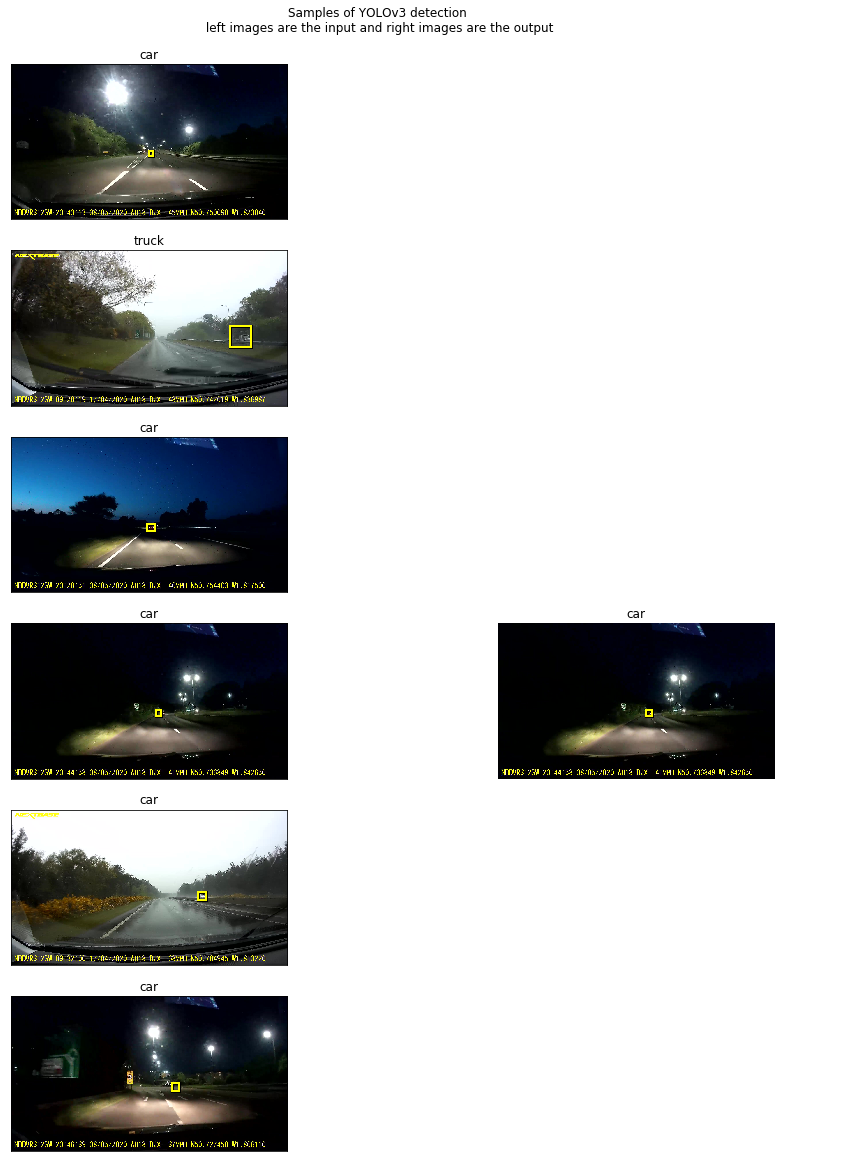

In [129]:
ix = [random.randrange(0,frames_list.shape[0]) for i in range(6)] 

fig,ax = plt.subplots(len(ix),2,figsize=(16,20))
ttl = fig.suptitle(f'Samples of YOLOv3 detection\n left images are the input and right images are the output')
ttl.set_position([.5, .92])
for i in tqdm(ix):
    # showing the input bbox
    lbl,bbox = bbox_inp(i)
    
    show_inp(i,lbl=lbl,bbox=bbox,ax=ax[ix.index(i),0])
    # showing the predicted bbox
     
    detections = YOLO_pred(i)[0]
    ax[ix.index(i),1].axis('off')
    if detections is not None:
        show_pred(i,detections=detections,ax=ax[ix.index(i),1])

As it is obvious, some input images had no detection at all

## Faster_RCNN

In [105]:
os.chdir('..')

In [30]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

### Parametrs

For FAST_RCNN we found a pre-trained network which was tranied on a different COCO dataset. SO we had to define another COCO names.https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/

In [31]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

i2c = lambda i : [k for k,v in targets.items() if v ==i]
c2i = {k:v for v,k in enumerate(COCO_INSTANCE_CATEGORY_NAMES)}

targets= {'car':c2i['car'],'truck':c2i['truck'],'bus':c2i['bus'],'motorcycle':c2i['motorcycle']} # object classes
targets

{'car': 3, 'truck': 8, 'bus': 6, 'motorcycle': 4}

In [32]:
# input image size
inp_w = 300
inp_h = 400

In [33]:
def FRCNN_pred(img_idx):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    
    img = PIL.Image.open(img_path)
    
    imh,imw = detect_image(img)
    
    
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)), 
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
     
    
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    
    with torch.no_grad():
        detections = model(input_img)
        
    return detections
    

### Loading Faster_RCNN

In [34]:
# loading the model
torch.cuda.empty_cache()

model = fasterrcnn_resnet50_fpn(pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

### Prdediction

In [35]:
class_correct_FRCNN = {'car':0,'truck':0,'bus':0,'motorcycle':0} # to count number of correct detected classes
class_notcorrect_FRCNN = {'car':0,'truck':0,'bus':0,'motorcycle':0}

class_correct_FRCNN_night = {'car':0,'truck':0,'motorcycle':0}   #per condition split
class_notcorrect_FRCNN_night = {'car':0,'truck':0,'motorcycle':0} # night doesnt have bus messes up recall later on

class_correct_FRCNN_rain = {'car':0,'truck':0,'bus':0} # rain doesnt have motorcycle it messes up recall formula later
class_notcorrect_FRCNN_rain = {'car':0,'truck':0,'bus':0}

class_correct_FRCNN_clear = {'car':0,'truck':0,'bus':0,'motorcycle':0} 
class_notcorrect_FRCNN_clear = {'car':0,'truck':0,'bus':0,'motorcycle':0}

root_dir = 'Frames/'
correct = 0
detected = 0
not_detected = 0
trsh = .6
for image_idx in trange(frames_list.shape[0]):

    cls_name = frames_list.iloc[image_idx,1] # class name
    y = targets[cls_name] # convert to intiger
    
    if 'Night' in frames_list.iloc[image_idx,0]:
        condition = 'night'
    elif 'Rainy' in frames_list.iloc[image_idx,0]:
        condition = 'rain'
    else:
        condition = 'clear'
    
    detections = FRCNN_pred(image_idx)
    
    if detections is not None:
                labels = detections[0]['labels'].cpu().tolist()
                scores = detections[0]['scores'].cpu().tolist()
                scores_ =[x for x in scores if x>trsh] # applying a threshold to the confidence scores
                
                if len(scores_)!=0:
                    scores_.sort()
                    mx_scores_idx =scores_.index(scores_[-1]) # finding the maximum score
                    
                    if mx_scores_idx !=0:
                        y_ = labels[:mx_scores_idx+1] # 
                else:
                    y_ =[]
                    
                if len(y_)!=0:    

                    if y in y_:
                        class_correct_FRCNN[cls_name] +=1
                        correct +=1
                        if condition == 'night':
                            class_correct_FRCNN_night[cls_name] += 1
                        elif condition == 'rain':
                            class_correct_FRCNN_rain[cls_name] += 1
                        else:
                            class_correct_FRCNN_clear[cls_name] += 1 
                    else:
                        class_notcorrect_FRCNN[cls_name] +=1
                        if condition == 'night':
                            class_notcorrect_FRCNN_night[cls_name] += 1
                        elif condition == 'rain':
                            class_notcorrect_FRCNN_rain[cls_name] += 1
                        else:
                            class_notcorrect_FRCNN_clear[cls_name] += 1 
                        

                else:
                     not_detected+=1

In [36]:
# claclute the number of not detected objects per class
correct_notcorrect ={k:class_correct_FRCNN.get(k, 0) + class_notcorrect_FRCNN.get(k, 0) for k in set(class_correct_FRCNN)}

class_not_detected = {k: class_total.get(k, 0) - correct_notcorrect.get(k, 0) for k in set(class_total)}

detected = frames_list.shape[0]-not_detected

#rain not detected
correct_notcorrect_rain ={k:class_correct_FRCNN_rain.get(k, 0) + class_notcorrect_FRCNN_rain.get(k, 0) for k in set(class_correct_FRCNN_rain)}

class_not_detected_rain = {k: cls_cnt_rain.get(k, 0) - correct_notcorrect_rain.get(k, 0) for k in set(cls_cnt_rain)}

#night not detected
correct_notcorrect_night ={k:class_correct_FRCNN_night.get(k, 0) + class_notcorrect_FRCNN_night.get(k, 0) for k in set(class_correct_FRCNN_night)}

class_not_detected_night = {k: cls_cnt_night.get(k, 0) - correct_notcorrect_night.get(k, 0) for k in set(cls_cnt_night)}

#clear not detected
correct_notcorrect_clear ={k:class_correct_FRCNN_clear.get(k, 0) + class_notcorrect_FRCNN_clear.get(k, 0) for k in set(class_correct_FRCNN_clear)}

class_not_detected_clear = {k: cls_cnt_clear.get(k, 0) - correct_notcorrect_clear.get(k, 0) for k in set(cls_cnt_clear)}

In [37]:
print(color.BOLD + 'FRCNN Overall' + color.END)
print(f'Accuracy of the FRCNNV3 on the {frames_list.shape[0]} test images: {100 * correct /frames_list.shape[0]:0.2f}%\n'
    
)

for k,_ in class_correct_FRCNN.items():
    precision_FRCNN = division(class_correct_FRCNN[k],class_notcorrect_FRCNN[k]+class_correct_FRCNN[k])
    print(f'precision of {k}: {precision_FRCNN:0.2f}')
  
    recall_FRCNN = division(class_correct_FRCNN[k],class_correct_FRCNN[k]+class_not_detected[k])
    print(f'recall of {k}: {recall_FRCNN:0.2f}')
    
    F1_FRCNN = 2*(division((recall_FRCNN*precision_FRCNN),(recall_FRCNN+precision_FRCNN)))
    print(f'F1 of {k}: {F1_FRCNN:0.2f}')
    
    print('')
    
print(color.BOLD + 'Rain Condition' + color.END)
print(f'Accuracy of the FRCNNV3 on {sum(cls_cnt_rain.values())} Rain test images: {100 * sum(class_correct_FRCNN_rain.values())/sum(cls_cnt_rain.values()):0.2f}%\n'
    
)

for k,_ in class_correct_FRCNN_rain.items():
    
    precision_FRCNN_rain = division(class_correct_FRCNN_rain[k],class_notcorrect_FRCNN_rain[k]+class_correct_FRCNN_rain[k])
    print(f'precision of {k}: {precision_FRCNN_rain:0.2f}')
  
    recall_FRCNN_rain = division(class_correct_FRCNN_rain[k],class_correct_FRCNN_rain[k]+class_not_detected_rain[k])
    print(f'recall of {k}: {recall_FRCNN_rain:0.2f}')
    
    F1_FRCNN_rain = 2*(division((recall_FRCNN_rain*precision_FRCNN_rain),(recall_FRCNN_rain+precision_FRCNN_rain)))
    print(f'F1 of {k}: {F1_FRCNN_rain:0.2f}')
    
    print('')

print(color.BOLD + 'Night Condition' + color.END)
print(f'Accuracy of the FRCNNV3 on {sum(cls_cnt_night.values())} Night test images: {100 * sum(class_correct_FRCNN_night.values())/sum(cls_cnt_night.values()):0.2f}%\n'
    
)

for k,_ in class_correct_FRCNN_night.items():
    
    precision_FRCNN_night = division(class_correct_FRCNN_night[k],class_notcorrect_FRCNN_night[k]+class_correct_FRCNN_night[k])
    print(f'precision of {k}: {precision_FRCNN_night:0.2f}')
  
    recall_FRCNN_night = division(class_correct_FRCNN_night[k],class_correct_FRCNN_night[k]+class_not_detected_night[k])
    print(f'recall of {k}: {recall_FRCNN_night:0.2f}')
    
    F1_FRCNN_night = 2*(division((recall_FRCNN_night*precision_FRCNN_night),(recall_FRCNN_night+precision_FRCNN_night)))
    print(f'F1 of {k}: {F1_FRCNN_night:0.2f}')
    
    print('')
    
#print(color.BOLD + 'Clear Condition' + color.END)
# print(f'Accuracy of the FRCNNV3 on {sum(cls_cnt_clear.values())} Night test images: {100 * sum(class_correct_FRCNN_clear.values())/sum(cls_cnt_clear.values()):0.2f}%\n'
    
# )

# for k,_ in class_correct_FRCNN_clear.items():
    
#     precision_FRCNN_clear = division(class_correct_FRCNN_clear[k],class_notcorrect_FRCNN_clear[k]+class_correct_FRCNN_clear[k])
#     print(f'precision of {k}: {precision_FRCNN_clear:0.2f}')
  
#     recall_FRCNN_clear = division(class_correct_FRCNN_clear[k],class_correct_FRCNN_clear[k]+class_not_detected_clear[k])
#     print(f'recall of {k}: {recall_FRCNN_clear:0.2f}')
    
#     F1_FRCNN_clear = 2*(division((recall_FRCNN_clear*precision_FRCNN_clear),(recall_FRCNN_clear+precision_FRCNN_clear)))
#     print(f'F1 of {k}: {F1_FRCNN_clear:0.2f}')
    
#     print('')


FRCNN Overall
Accuracy of the FRCNNV3 on the 7292 test images: 21.52%

precision of car: 0.92
recall of car: 0.22
F1 of car: 0.36

precision of truck: 0.45
recall of truck: 0.29
F1 of truck: 0.35

precision of bus: 0.17
recall of bus: 0.08
F1 of bus: 0.11

precision of motorcycle: 0.00
recall of motorcycle: 0.00
F1 of motorcycle: 0.00

Rain Condition
Accuracy of the FRCNNV3 on 1066 Rain test images: 40.81%

precision of car: 0.94
recall of car: 0.48
F1 of car: 0.64

precision of truck: 0.49
recall of truck: 0.34
F1 of truck: 0.40

precision of bus: 0.17
recall of bus: 0.08
F1 of bus: 0.11

Night Condition
Accuracy of the FRCNNV3 on 6226 Night test images: 18.21%

precision of car: 0.91
recall of car: 0.19
F1 of car: 0.31

precision of truck: 0.31
recall of truck: 0.16
F1 of truck: 0.21

precision of motorcycle: 0.00
recall of motorcycle: 0.00
F1 of motorcycle: 0.00



## SSD

For doing prediction with SSD we used a pretrained  <a href="https://github.com/qfgaohao/pytorch-ssd">SSD-vgg16</a>

In [39]:
os.chdir('ObjectDetection_Compare_BU')

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'ObjectDetection_Compare_BU'

In [40]:
os.getcwd()

'D:\\ObjectDetection_Compare_BU'

In [41]:
!git clone "https://github.com/qfgaohao/pytorch-ssd.git"
os.chdir('pytorch-ssd')

fatal: destination path 'pytorch-ssd' already exists and is not an empty directory.


In [42]:
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
from vision.utils.misc import Timer
import cv2

### Parameters

Since this model has been trained on VOC dataset and 'truck' is not a valid class in this dataset, we first had to remove 'truck' from our dataset.

In [43]:
csv_file = '../mergedlbls.csv'
frames_list = pd.read_csv(csv_file)
trucks = frames_list.loc[frames_list.class_id == 'truck']
truck_indexes = trucks.index
frames_list = frames_list.drop(index=truck_indexes)
frames_list.head()

,im_name,class_id,Xc,Yc,w,h
31,RainyDay2/00111.jpg,car,1141,613,55,36
32,RainyDay2/00112.jpg,car,1179,614,62,43
35,RainyDay2/00113.jpg,car,1233,612,72,51
36,RainyDay2/00114.jpg,car,1316,605,104,58
37,RainyDay2/00114.jpg,car,1122,606,56,42


The new dataset has 3 classes as follows:

In [44]:
cls_cnt = frames_list.iloc[:,1].value_counts()
cls_cnt_rain = frames_list[frames_list['im_name'].str.contains('Rainy')].iloc[:,1].value_counts().to_dict()
cls_cnt_night = frames_list[frames_list['im_name'].str.contains('Night')].iloc[:,1].value_counts().to_dict()
cls_cnt_clear = frames_list[frames_list['im_name'].str.contains('Clear')].iloc[:,1].value_counts().to_dict()
class_total =cls_cnt.to_dict()
class_total

{'car': 6904, 'bus': 18, 'motorcycle': 14}

we did a correspondace between the dataset classes and VOC classes

In [45]:
VOC_NAMES =['background','aeroplane','bicycle','bird','boat','bottle',
              'bus','car','cat','chair','cow','diningtable','dog','horse',
              'motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
c2i = {k:v for v,k in enumerate(VOC_NAMES)}
targets= {'car':c2i['car'],'bus':c2i['bus'],'motorcycle':c2i['motorbike']} # object classes
i2c = lambda i : [k for k,v in targets.items() if v ==i]
targets

{'car': 7, 'bus': 6, 'motorcycle': 14}

To download the weights for the pretrained model from <a href="https://storage.googleapis.com/models-hao/vgg16-ssd-mp-0_7726.pth">here</a>

In [46]:
model_path = 'vgg16-ssd-mp-0_7726.pth'

## loading model

In [47]:
torch.cuda.empty_cache()
net = create_vgg_ssd(len(VOC_NAMES), is_test=True)

net.load(model_path)

In [48]:
predictor = create_vgg_ssd_predictor(net, candidate_size=200)

In [49]:
def SSD_pred(img_idx, trsh):
    
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    
    orig_image = cv2.imread(img_path)
    img = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    
    with torch.no_grad():
         bbox, classes, confidences = predictor.predict(img, 10, trsh)

    return bbox, classes, confidences
    

In [50]:
cd ..

D:\ObjectDetection_Compare_BU


In [51]:
class_correct_SSD = {'car':0,'bus':0,'motorcycle':0} # to count number of correct detected classes
class_notcorrect_SSD = {'car':0,'bus':0,'motorcycle':0}

class_correct_SSD_night = {'car':0,'motorcycle':0}   #per condition split
class_notcorrect_SSD_night = {'car':0,'motorcycle':0} # night doesnt have bus messes up recall later on

class_correct_SSD_rain = {'car':0,'bus':0} # rain doesnt have motorcycle it messes up recall formula later
class_notcorrect_SSD_rain = {'car':0,'bus':0}

class_correct_SSD_clear = {'car':0,'bus':0,'motorcycle':0} 
class_notcorrect_SSD_clear = {'car':0,'bus':0,'motorcycle':0}

root_dir = 'Frames/'
correct = 0
detected = 0
not_detected = 0
trsh = .5
old_stdout = sys.stdout
for image_idx in trange(frames_list.shape[0]):

    cls_name = frames_list.iloc[image_idx,1] # class name
    y = targets[cls_name] # convert to intiger
    sys.stdout = open(os.devnull,'w') # to prevent print out the out put net results
    
    if 'Night' in frames_list.iloc[image_idx,0]:
        condition = 'night'
    elif 'Rainy' in frames_list.iloc[image_idx,0]:
        condition = 'rain'
    else:
        condition = 'clear'
    
    _,y_,confidences = SSD_pred(image_idx,trsh)

    if y_.size()[0] !=0:
        
        if y in y_:
            class_correct_SSD[cls_name] +=1
            correct +=1
            if condition == 'night':
                class_correct_SSD_night[cls_name] += 1
            elif condition == 'rain':
                class_correct_SSD_rain[cls_name] += 1
            else:
                class_correct_SSD_clear[cls_name] += 1
        else:
            class_notcorrect_SSD[cls_name] +=1
            
            if condition == 'night':
                class_notcorrect_SSD_night[cls_name] += 1
            elif condition == 'rain':
                class_notcorrect_SSD_rain[cls_name] += 1
            else:
                class_notcorrect_SSD_clear[cls_name] += 1 
    else:
         not_detected+=1
            
            
sys.stdout.close()
sys.stdout = old_stdout
 

In [54]:
# claclute the number of not detected objects per class
correct_notcorrect ={k:class_correct_SSD.get(k, 0) + class_notcorrect_SSD.get(k, 0) for k in set(class_correct_SSD)}

class_not_detected = {k: class_total.get(k, 0) - correct_notcorrect.get(k, 0) for k in set(class_total)}

detected = frames_list.shape[0]-not_detected

#rain not detected
correct_notcorrect_rain ={k:class_correct_SSD_rain.get(k, 0) + class_notcorrect_SSD_rain.get(k, 0) for k in set(class_correct_SSD_rain)}

class_not_detected_rain = {k: cls_cnt_rain.get(k, 0) - correct_notcorrect_rain.get(k, 0) for k in set(cls_cnt_rain)}

#night not detected
correct_notcorrect_night ={k:class_correct_SSD_night.get(k, 0) + class_notcorrect_SSD_night.get(k, 0) for k in set(class_correct_SSD_night)}

class_not_detected_night = {k: cls_cnt_night.get(k, 0) - correct_notcorrect_night.get(k, 0) for k in set(cls_cnt_night)}

#clear not detected
correct_notcorrect_clear ={k:class_correct_SSD_clear.get(k, 0) + class_notcorrect_SSD_clear.get(k, 0) for k in set(class_correct_SSD_clear)}

class_not_detected_clear = {k: cls_cnt_clear.get(k, 0) - correct_notcorrect_clear.get(k, 0) for k in set(cls_cnt_clear)}

In [57]:
print(color.BOLD + 'SSD Overall' + color.END)
print(f'Accuracy of the SSD on the {frames_list.shape[0]} test images: {100 * correct /frames_list.shape[0]:0.2f}%\n'
    
)

for k,_ in class_correct_SSD.items():
    precision_SSD = division(class_correct_SSD[k],class_notcorrect_SSD[k]+class_correct_SSD[k])
    print(f'precision of {k}: {precision_SSD:0.2f}')
  
    recall_SSD = division(class_correct_SSD[k],class_correct_SSD[k]+class_not_detected[k])
    print(f'recall of {k}: {recall_SSD:0.2f}')
    
    F1_SSD = 2*(division((recall_SSD*precision_SSD),(recall_SSD+precision_SSD)))
    print(f'F1 of {k}: {F1_SSD:0.2f}')
    
    print('')
    
print(color.BOLD + 'Rain Condition' + color.END)
print(f'Accuracy of the SSD on {sum(cls_cnt_rain.values())} Rain test images: {100 * sum(class_correct_SSD_rain.values())/sum(cls_cnt_rain.values()):0.2f}%\n'
    
)

for k,_ in class_correct_SSD_rain.items():
    
    precision_SSD_rain = division(class_correct_SSD_rain[k],class_notcorrect_SSD_rain[k]+class_correct_SSD_rain[k])
    print(f'precision of {k}: {precision_SSD_rain:0.2f}')
  
    recall_SSD_rain = division(class_correct_SSD_rain[k],class_correct_SSD_rain[k]+class_not_detected_rain[k])
    print(f'recall of {k}: {recall_SSD_rain:0.2f}')
    
    F1_SSD_rain = 2*(division((recall_SSD_rain*precision_SSD_rain),(recall_SSD_rain+precision_SSD_rain)))
    print(f'F1 of {k}: {F1_SSD_rain:0.2f}')
    
    print('')

print(color.BOLD + 'Night Condition' + color.END)
print(f'Accuracy of the SSD on {sum(cls_cnt_night.values())} Night test images: {100 * sum(class_correct_SSD_night.values())/sum(cls_cnt_night.values()):0.2f}%\n'
    
)

for k,_ in class_correct_SSD_night.items():
    
    precision_SSD_night = division(class_correct_SSD_night[k],class_notcorrect_SSD_night[k]+class_correct_SSD_night[k])
    print(f'precision of {k}: {precision_SSD_night:0.2f}')
  
    recall_SSD_night = division(class_correct_SSD_night[k],class_correct_SSD_night[k]+class_not_detected_night[k])
    print(f'recall of {k}: {recall_SSD_night:0.2f}')
    
    F1_SSD_night = 2*(division((recall_SSD_night*precision_SSD_night),(recall_SSD_night+precision_SSD_night)))
    print(f'F1 of {k}: {F1_SSD_night:0.2f}')
    
    print('')
    
#print(color.BOLD + 'Clear Condition' + color.END)
# print(f'Accuracy of the SSDV3 on {sum(cls_cnt_clear.values())} Night test images: {100 * sum(class_correct_SSD_clear.values())/sum(cls_cnt_clear.values()):0.2f}%\n'
    
# )

# for k,_ in class_correct_SSD_clear.items():
    
#     precision_SSD_clear = division(class_correct_SSD_clear[k],class_notcorrect_SSD_clear[k]+class_correct_SSD_clear[k])
#     print(f'precision of {k}: {precision_SSD_clear:0.2f}')
  
#     recall_SSD_clear = division(class_correct_SSD_clear[k],class_correct_SSD_clear[k]+class_not_detected_clear[k])
#     print(f'recall of {k}: {recall_SSD_clear:0.2f}')
    
#     F1_SSD_clear = 2*(division((recall_SSD_clear*precision_SSD_clear),(recall_SSD_clear+precision_SSD_clear)))
#     print(f'F1 of {k}: {F1_SSD_clear:0.2f}')
    
#     print('')


SSD Overall
Accuracy of the SSD on the 6936 test images: 21.73%

precision of car: 0.80
recall of car: 0.23
F1 of car: 0.36

precision of bus: 0.00
recall of bus: 0.00
F1 of bus: 0.00

precision of motorcycle: 0.00
recall of motorcycle: 0.00
F1 of motorcycle: 0.00

Rain Condition
Accuracy of the SSD on 805 Rain test images: 11.30%

precision of car: 0.33
recall of car: 0.15
F1 of car: 0.21

precision of bus: 0.00
recall of bus: 0.00
F1 of bus: 0.00

Night Condition
Accuracy of the SSD on 6131 Night test images: 23.10%

precision of car: 0.88
recall of car: 0.24
F1 of car: 0.38

precision of motorcycle: 0.00
recall of motorcycle: 0.00
F1 of motorcycle: 0.00



# Discussion and Results

## Comparison table

In [20]:
comp_tbl= pd.DataFrame(0, index=['YOLOv3','Faster_RCNN','SSD_vgg16'],
                      columns=['car','truck','bus','motorcycle'])

comp_tbl.loc['YOLOv3'] = class_correct_YOLO
comp_tbl.loc['Faster_RCNN'] = class_correct_FRCNN
comp_tbl.loc['SSD_vgg16'] = class_correct_SSD
comp_tbl['sum'] = comp_tbl.sum(axis=1)
comp_tbl['acc'] = comp_tbl['sum']/frames_list.shape[0]
comp_tbl.round(decimals=2)

NameError: name 'class_correct_YOLO' is not defined